In [ ]:
# How many stacked exposures are required for a detection as a function of distance? 

In [209]:
# Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import os
from astropy.io import fits
from astropy.table import Table, QTable
from astroduet.background import background_pixel_rate
from astroduet.config import Telescope
from astroduet.utils import duet_abmag_to_fluence, galex_to_duet
from astroduet.image_utils import construct_image, estimate_background, find, run_daophot
from astroduet.diff_image import py_zogy, calculate_diff_image
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
from astroduet.models import load_bai

# Set up Telescope and values common to all light curves
duet = Telescope()
[bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi = True)
psf_fwhm_pix = duet.psf_fwhm / duet.pixel
psf_array = duet.psf_model(x_size=5,y_size=5).array

frame = np.array([30,30])
exposure = 300 * u.s
oversample = 6
pixel_size_init = duet.pixel / oversample

# Load up the Bai table
bai = QTable(load_bai())
bai['BAI1'], bai['BAI2'] = galex_to_duet([bai['SURFFUV'].value, bai['SURFNUV'].value], duet=duet)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: ResourceWarning: unclosed file <_io.TextIOWrapper name='../astroduet/data/bai_data/Table2.txt' mode='r' encoding='UTF-8'>


In [180]:
print(bai.columns)

<TableColumns names=('PGC','DIST','LUMFUV','LUMNUV','RAD','MORPH','AREA','SURFNUV','SURFFUV','BAI1','BAI2')>


In [247]:
# Take input: number of pointings, distance (anything about position - zodi etc.?)
emgw = QTable([[2,3,4,5,6], [70,50,80,100,40] * u.Mpc], names=('pointings', 'distance'))

# Generate simulation data (runtime: ~20-30s per event)
for i, e in enumerate(emgw):
    
    # Generate a background galaxy from Bai catalogue
    # Pick within a distance range
    galaxy = np.random.choice(bai[(bai['DIST'] > (e['distance']-10*u.Mpc)) & (bai['DIST'] < (e['distance']+10*u.Mpc))])
    
    # Correct radius for distance
    rad = galaxy['RAD'] * u.arcsec * galaxy['DIST'] * u.Mpc / e['distance']
    rad_pix = rad / pixel_size_init
    
    # Base n on Hubble type
    if galaxy['MORPH'] >= 0: n = 1 
    else: n = 4

    # Randomise theta, ellip, position as fraction of r_eff
    theta = np.random.uniform(low=0,high=np.pi)
    ellip = np.random.uniform(low=0.1,high=1)
    pos = np.random.uniform(low=0.1,high=3) 
    
    # Calculate x_0 and y_0
    d = pos * rad / pixel_size_init
    x_0 = d * np.cos(theta) 
    y_0 = d * np.sin(theta)
    
    # Set up galaxy parameters
    gal_params1 = {'magnitude': galaxy['BAI1'], 'r_eff': rad_pix.value, 'n': n, 'theta': theta, \
                   'ellip': ellip, 'x_0': x_0.value, 'y_0': y_0.value}
    gal_params2 = {'magnitude': galaxy['BAI2'], 'r_eff': rad_pix.value, 'n': n, 'theta': theta, \
                   'ellip': ellip, 'x_0': x_0.value, 'y_0': y_0.value}
    
    # Next, generate the light curve for the shock and blue kilonova models
    # Assume we start tiling half an hour after the event, at a random orbit phase
    start_time = 1800 * u.s + np.random.choice(np.arange(e['pointings'])+1) * exposure
    end_time = 21600. * u.s # Only generate a quarter day's data for now (maybe base on tiling strategy?)
    phase_start = np.random.random()
    
    # Get lightcurve first then sort out the pointings (inefficient but best we can do with infrastructure)
    observing_windows = np.array([[start_time.to(u.s).value,end_time.to(u.s).value]]) * u.s
    file = "emgw{}".format(i)
    
    # Get lightcurve through images with debug on so it's storing files
    lightcurve_shock = get_lightcurve("shock_5e10.dat", distance=e['distance'], exposure=exposure, duet=duet,
                                        observing_windows=observing_windows)
    im_lightcurve_shock = lightcurve_through_image(lightcurve_shock, exposure=exposure, frame=frame, duet=duet,
                                                   gal_type='custom', gal_params=gal_params1,
                                                   debug=True, debugfilename=file+'_shock')
            
    lightcurve_blukn = get_lightcurve("kilonova_0.04.dat", distance=e['distance'], exposure=exposure, duet=duet,
                                      observing_windows=observing_windows)
    im_lightcurve_blukn = lightcurve_through_image(lightcurve_blukn, exposure=exposure, frame=frame, duet=duet,
                                                   gal_type='custom', gal_params=gal_params1,
                                                   debug=True, debugfilename=file+'_blukn')
            
    print("Done: "+file)

INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw0
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw1
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw2
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw3
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw4


Now running shock
0 70.0 Mpc shock 2 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


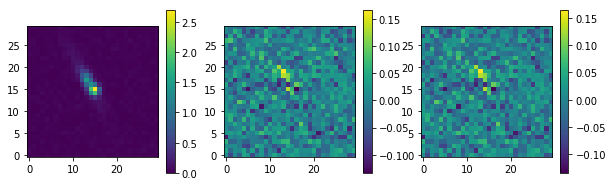

DUET2
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
14.426183864925445 14.779825254522605 1.9616535516707303 0.2264177269815812
11.049743518154141  15.26715006853007 19.200719283908377 3.2391317433002556


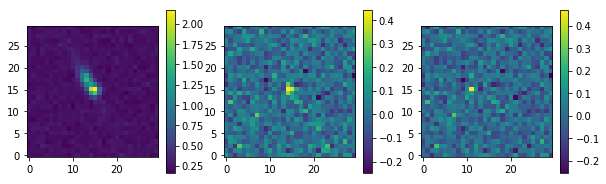

Now running blukn
0 70.0 Mpc blukn 5 BOTH
DUET1
      x_fit             y_fit             flux_fit          flux_unc     
                                           ph / s            ph / s      
----------------- ------------------ ----------------- ------------------
14.57969857024865 15.164451015983962 2.560097496530374 0.5072106997921175


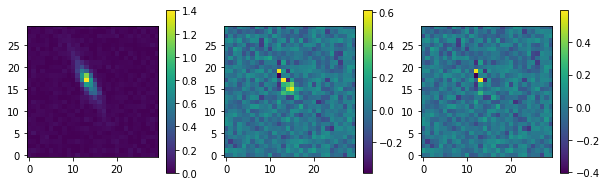

DUET2
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
15.281029078592741 14.464206040003779 2.9444868451498913 0.5168705248543927


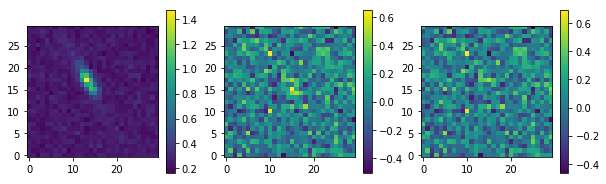

Now running shock
emgw1_shock shock 50.0 Mpc False Positive (band 2)
1 50.0 Mpc shock 1 DUET2
DUET1
      x_fit             y_fit            flux_fit      flux_unc
                                          ph / s        ph / s 
----------------- ----------------- ------------------ --------
11.31090173594025 7.047967963758916 -7.912462565469955      0.0


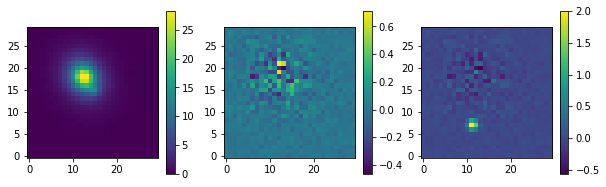

DUET2
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
14.728505096963321 15.054110968134367 2.9027850264987967 0.5774372112347457


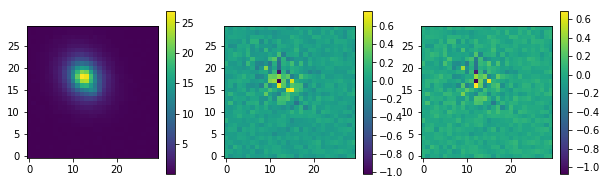

1 50.0 Mpc shock 2 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


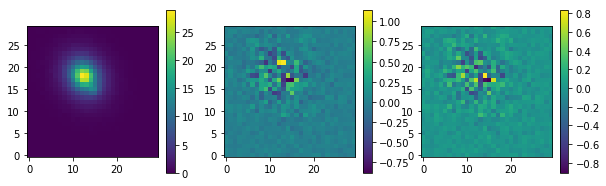

DUET2
      x_fit             y_fit            flux_fit          flux_unc     
                                          ph / s            ph / s      
----------------- ----------------- ----------------- ------------------
14.54134744964898 14.95793593743899 3.897021926190705 0.7721298947390219


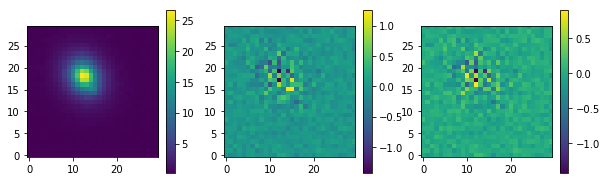

Now running blukn
1 50.0 Mpc blukn 4 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


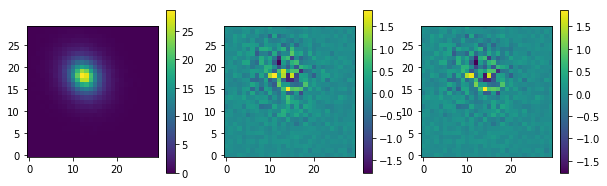

DUET2
      x_fit             y_fit             flux_fit          flux_unc     
                                           ph / s            ph / s      
----------------- ------------------ ----------------- ------------------
15.19475576848305 14.684380534009597 8.248772697287054 1.4357343183107074


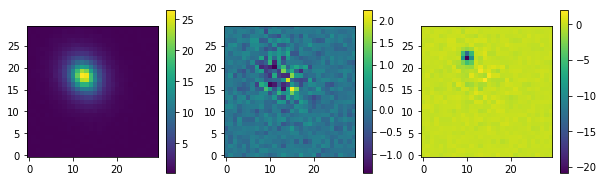

Now running shock
2 80.0 Mpc shock 2 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


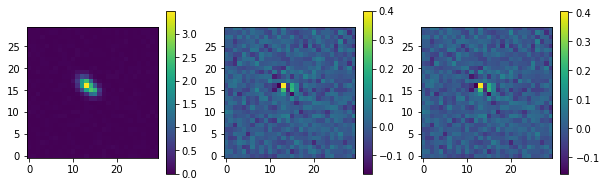

DUET2
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.778103383869244 14.875563947826105 2.4559429231409813 0.37266147902452307


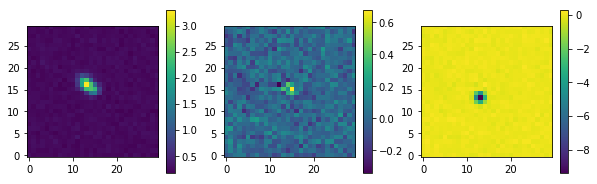

Now running blukn
2 80.0 Mpc blukn 4 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


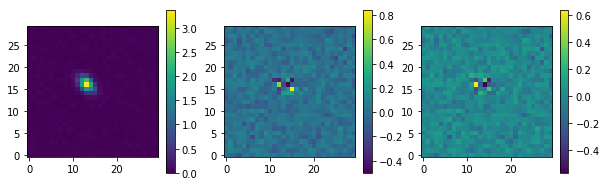

DUET2
      x_fit              y_fit             flux_fit          flux_unc     
                                            ph / s            ph / s      
------------------ ------------------ ----------------- ------------------
14.840000137794378 14.630371358958486 3.121929842420668 0.5716078166242117


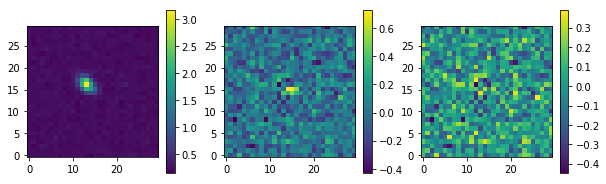

Now running shock
3 100.0 Mpc shock 4
DUET1 (inverse)
      x_fit             y_fit             flux_fit          flux_unc     
                                           ph / s            ph / s      
----------------- ------------------ ----------------- ------------------
14.71479473534175 14.799015728951748 4.927891665579115 0.5116039303147449


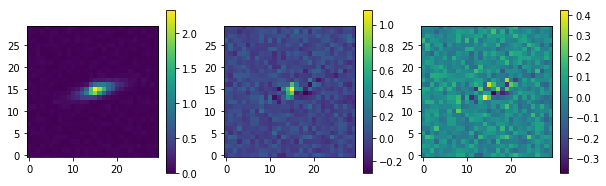

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


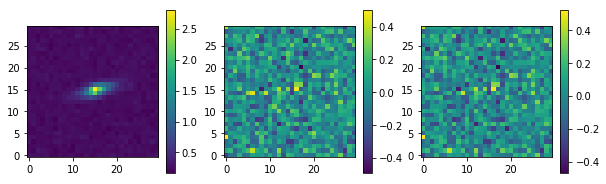

Now running blukn
3 100.0 Mpc blukn 4 DUET1
DUET1
      x_fit              y_fit            flux_fit           flux_unc     
                                           ph / s             ph / s      
------------------ ----------------- ----------------- -------------------
16.563584948315068 15.12131553951586 1.014285346065347 0.15425782234913663


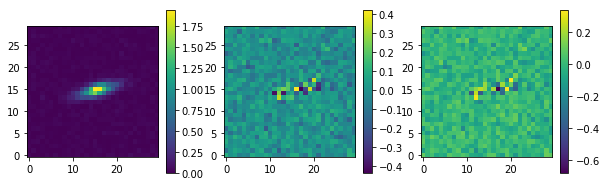

DUET2
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


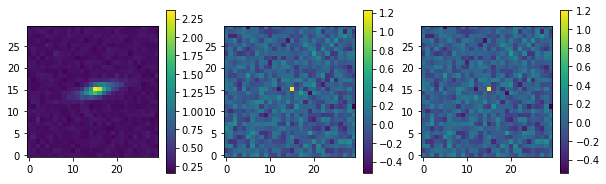

Now running shock
emgw4_shock shock 40.0 Mpc False Positive (band 1)
4 40.0 Mpc shock 1 BOTH
DUET1
      x_fit             y_fit             flux_fit          flux_unc    
                                           ph / s            ph / s     
----------------- ------------------ ----------------- -----------------
14.91031983908662 15.780412507450164 3.062233972500776 0.525166227947902


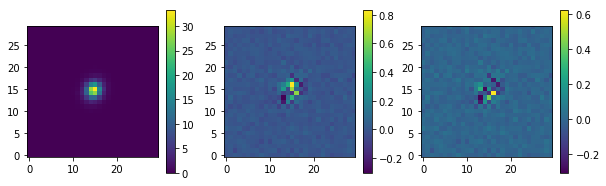

DUET2
      x_fit              y_fit             flux_fit          flux_unc     
                                            ph / s            ph / s      
------------------ ------------------ ----------------- ------------------
14.858613872254585 15.066252585908957 4.354285071027626 0.6037788059461268


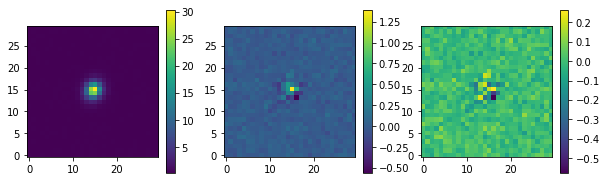

4 40.0 Mpc shock 2 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


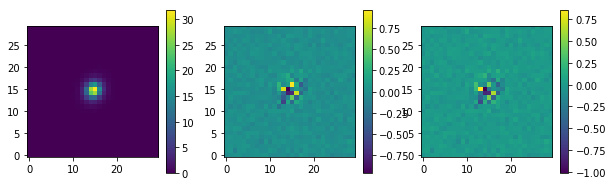

DUET2
      x_fit              y_fit             flux_fit          flux_unc     
                                            ph / s            ph / s      
------------------ ------------------ ----------------- ------------------
14.807297632784117 15.127679742500469 7.648896533023591 1.0172388975442976


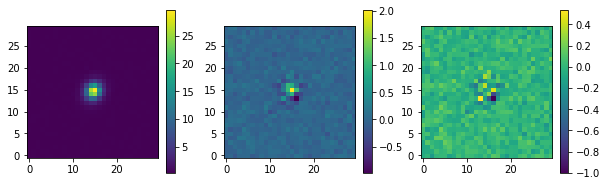

Now running blukn
 id pointings distance model num_exp    band   false
--- --------- -------- ----- ------- --------- -----
  0         2       70 shock       2     DUET2     0
  0         2       70 blukn       5      BOTH     0
  1         3       50 shock       1     DUET2     1
  1         3       50 shock       2     DUET2     0
  1         3       50 blukn       4     DUET2     0
  2         4       80 shock       2     DUET2     0
  2         4       80 blukn       4     DUET2     0
  3         5      100 shock       4 DUET1_inv     0
  3         5      100 blukn       4     DUET1     0
  4         6       40 shock       1      BOTH     1
  4         6       40 shock       2     DUET2     0
  4         6       40 blukn      -1      NONE     0


In [258]:
def find_check(img,psf_fwhm_pix,input_fluence):
    star_tbl, bkg_image, threshold = find(img,psf_fwhm_pix,
                                          method='daophot',background='1D',frame='diff',diag=False)
    result_tbl, residual = run_daophot(img,threshold,star_tbl,snr_lim=5,duet=duet,diag=False)
                        
    # Check it's the source (i.e. near center)
    found, false_pos, frac_diff = 0, 0, 0
    if len(result_tbl) > 0:
        sep = np.sqrt((result_tbl['x_fit']-(frame[0]//2))**2 + (result_tbl['y_fit']-(frame[1]//2))**2)
        closest = np.argmin(sep)
        if np.amin(sep) <= 2:
            res = result_tbl[closest]
            # Sanity check, is this close to the rate that you would expect?                     
            found_rate = res['flux_fit']
            true_rate = duet.fluence_to_rate(input_fluence).value
            frac_diff = abs(found_rate - true_rate) / true_rate
            if frac_diff > 0.8:
                false_pos = 1 
            # Even if it's a false positive, the telescope won't know
            found = 1
    
    return result_tbl, found, false_pos, frac_diff, residual


# For each event, loop through exposures until a source is detected, insert number into results table
debugdir = os.path.join(os.getcwd(), 'debug_imgs')

results = Table(names=('id', 'pointings', 'distance', 'model', 'num_exp', 'band', 'false'), 
                dtype=('i2', 'i2', 'i2', 'S5', 'i2', 'S9', 'i1'))

# Loop through the light curves for the events
for i, e in enumerate(emgw):
    
    distance = e['distance']
    
    # Loop through different models
    for mod in ['shock','blukn']:
        
        print('Now running '+mod)

        # Grab the lightcurve files we need 
        name = 'emgw{}_{}'.format(i,mod)
        table = Table.read(os.path.join(debugdir,name,name+'.hdf5'), path='default')
        
        # Loop through images, summing until we get a detection
        img_sum1, img_sum2 = np.zeros(frame) * u.ph / u.s, np.zeros(frame) * u.ph / u.s
        num_exp = 0
        fluence_sum1, fluence_sum2 = 0, 0
        detect = 0
        for row in table:
            if row.index == 0:
                # Rather than a reference image, we are using the t0 image while on the spacecraft
                # We can't add D1 and D2 on the spacecraft
                ref_rate1 = row['imgs_D1'] * u.ph / u.s
                ref_rate2 = row['imgs_D2'] * u.ph / u.s
            elif row.index % e['pointings'] == 0:
                # Only add exposures that are a multiple of the number of pointings
                num_exp += 1
                false = 0
                
                # Add both bands to create a summed image
                img_rate1 = row['imgs_D1'] * u.ph / u.s
                img_rate2 = row['imgs_D2'] * u.ph / u.s
                
                # Make a simple difference image
                diff_image1 = img_rate1 - ref_rate1
                diff_image2 = img_rate2 - ref_rate2
                
                # Add up the differences (note - if this goes on too long this may take us back below starting rate)
                # If we first detect the source at its peak, then the difference will be a strong negative
                # (though we could search for that too)
                img_sum1 += diff_image1
                img_sum2 += diff_image2
                
                # Run Find and then DAOPhot on img_sum (DAOPhot by default only returns srcs with snr >= 5)
                fluence_sum1 += row['fluence_D1'] - table['fluence_D1'][0]
                fluence_sum2 += row['fluence_D2'] - table['fluence_D2'][0]
                
                result_tbl1, found_d1, false_pos1, frac_diff1, residual1 = find_check(img_sum1,psf_fwhm_pix.value,
                                                                                      fluence_sum1)
                result_tbl2, found_d2, false_pos2, frac_diff2, residual2 = find_check(img_sum2,psf_fwhm_pix.value,
                                                                                      fluence_sum2)
                
                if false_pos1 == 1: 
                    print(name, mod, distance, 'False Positive (band 1)')
                    false = 1
                if false_pos2 == 1: 
                    print(name, mod, distance, 'False Positive (band 2)')
                    false = 1
                        
                # Source successfully found! 
                if (found_d1 == 1) | (found_d2 == 1):
                    # Record number of exposures it took, break loop
                    if (found_d1 == 1) & (found_d2 == 0): band = 'DUET1'
                    if (found_d2 == 1) & (found_d1 == 0): band = 'DUET2'   
                    if (found_d1 == 1) & (found_d2 == 1): band = 'BOTH'
                    results.add_row((i, e['pointings'], distance, mod, num_exp, band, false))
                    
                    print(i, distance, mod, num_exp, band)
                    
                    print('DUET1')
                    print(result_tbl1['x_fit','y_fit','flux_fit','flux_unc'])
                    plt.figure(figsize=(10,3))
                    plt.subplot(131)
                    plt.imshow(img_rate1.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.subplot(132)
                    plt.imshow(img_sum1.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.subplot(133)
                    plt.imshow(residual1.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.show()
                    
                    print('DUET2')
                    print(result_tbl2['x_fit','y_fit','flux_fit','flux_unc'])
                    plt.figure(figsize=(10,3))
                    plt.subplot(131)
                    plt.imshow(img_rate2.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.subplot(132)
                    plt.imshow(img_sum2.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.subplot(133)
                    plt.imshow(residual2.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.show()
                    
                    # Still continue if a false positive, we just want to record it
                    if false == 0:
                        detect = 1
                        break
                
                # We don't detect it, so flip the difference image and look for negative changes
                inv1, inv2 = -img_sum1, -img_sum2

                inv_tbl1, found_d1, false_pos1, frac_diff1, residual1 = find_check(inv1,psf_fwhm_pix.value,
                                                                                   -fluence_sum1)
                inv_tbl2, found_d2, false_pos2, frac_diff2, residual2 = find_check(inv2,psf_fwhm_pix.value,
                                                                                   -fluence_sum2)
                
                if false_pos1 == 1: 
                    print(name, mod, distance, 'False Positive (band 1), inverse')
                    false = 1
                if false_pos2 == 1: 
                    print(name, mod, distance, 'False Positive (band 2), inverse')
                    false = 1
                        
                # Source successfully found! 
                if (found_d1 == 1) | (found_d2 == 1):
                    # Record number of exposures it took, break loop
                    if (found_d1 == 1) & (found_d2 == 0): band = 'DUET1_inv'
                    if (found_d2 == 1) & (found_d1 == 0): band = 'DUET2_inv'   
                    if (found_d1 == 1) & (found_d2 == 1): band = 'BOTH_inv'
                    results.add_row((i, e['pointings'], distance, mod, num_exp, band, false))
                    
                    print(i, distance, mod, num_exp)
                    
                    print('DUET1 (inverse)')
                    print(inv_tbl1['x_fit','y_fit','flux_fit','flux_unc'])
                    plt.figure(figsize=(10,3))
                    plt.subplot(131)
                    plt.imshow(img_rate1.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.subplot(132)
                    plt.imshow(inv1.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.subplot(133)
                    plt.imshow(residual1.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.show()
                    
                    print('DUET2 (inverse)')
                    print(inv_tbl2['x_fit','y_fit','flux_fit','flux_unc'])
                    plt.figure(figsize=(10,3))
                    plt.subplot(131)
                    plt.imshow(img_rate2.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.subplot(132)
                    plt.imshow(inv2.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.subplot(133)
                    plt.imshow(residual2.value, cmap='viridis', aspect=1, origin='lower')
                    plt.colorbar()
                    plt.show()
                    
                    if false == 0:
                        detect = 1
                        break
            
        # If source hasn't been detected record this
        if detect == 0:
            results.add_row((i, e['pointings'], distance, mod, -1, 'NONE', 0))
                
print(results)